In [20]:
import numpy as np
import numpy.polynomial as P
import scipy as sp
from matplotlib import pyplot as plt
from tqdm import tqdm
#from sklearn.preprocessing import PolynomialFeatures
from multiprocessing import Pool
import multiprocessing
import ZVnbrosse
#from potentials import BayesGausMixture
from zv_cv import Eval_ZVCV_Gaus
from samplers import MCMC_sampler,Generate_train,ULA_light
from baselines import set_function,construct_ESVM_kernel,GenerateSigma, construct_Tukey_Hanning, set_function, Spectral_var, mult_W 
from martingale import approx_q,test_traj
from optimize import Run_eval_test,optimize_parallel_new 
from utils import *
import copy

In [21]:
"""
class BayesGausMixture:
    #Implements bayesian problem for estimating gaussian mixture parameters
    def __init__(self,mu_1,mu_2,sigma_x,sigma_theta,X):
        self.mu_1 = mu_1
        self.mu_2 = mu_2
        self.sigma_x = sigma_x
        self.sigma_param = sigma_theta
        self.X = copy.deepcopy(X)
        self.batch_size = 10

    def gradpotential(self,theta):
        theta_1 = theta[0]
        theta_2 = theta[1]
        sigma_x = self.sigma_x
        sigma_p = self.sigma_param
        grad = np.zeros(2, dtype = float)
        arg_1 = self.X - theta_1
        arg_2 = self.X - theta_2
        denom = 1 + np.exp((-arg_2**2 + arg_1**2)/(2*sigma_x**2))
        #print(denom)
        grad[0] = -theta_1/sigma_p**2 + (1/sigma_x**2)*np.sum(arg_1 / denom)
        grad[1] = -theta_2/sigma_p**2 + (1/sigma_x**2)*np.sum(arg_2*np.exp(-(arg_2**2 + arg_1**2) / (2*sigma_x**2)) / denom)
        return grad
    
    def stoch_grad(self,theta):
        N = len(self.X)
        #choose random batch for SGLD
        batch_inds = np.random.choice(N,self.batch_size)
        theta_1 = theta[0]
        theta_2 = theta[1]
        sigma_x = self.sigma_x
        sigma_p = self.sigma_param
        grad = np.zeros(2, dtype = float)
        arg_1 = self.X - theta_1
        arg_2 = self.X - theta_2
        denom = np.exp(-(arg_1)**2/(2*sigma_x**2)) + np.exp(-(arg_2)**2/(2*sigma_x**2))
        print(denom)
        grad[0] = -theta_1/sigma_p**2 + (N/(sigma_x**2 * self.batch_size))*np.sum((arg_1*np.exp(-arg_1**2 / (2*sigma_x**2)) / denom)[batch_inds])
        grad[1] = -theta_2/sigma_p**2 + (N/(sigma_x**2 * self.batch_size))*np.sum((arg_2*np.exp(-arg_2**2 / (2*sigma_x**2)) / denom)[batch_inds])
        return grad
"""

'\nclass BayesGausMixture:\n    #Implements bayesian problem for estimating gaussian mixture parameters\n    def __init__(self,mu_1,mu_2,sigma_x,sigma_theta,X):\n        self.mu_1 = mu_1\n        self.mu_2 = mu_2\n        self.sigma_x = sigma_x\n        self.sigma_param = sigma_theta\n        self.X = copy.deepcopy(X)\n        self.batch_size = 10\n\n    def gradpotential(self,theta):\n        theta_1 = theta[0]\n        theta_2 = theta[1]\n        sigma_x = self.sigma_x\n        sigma_p = self.sigma_param\n        grad = np.zeros(2, dtype = float)\n        arg_1 = self.X - theta_1\n        arg_2 = self.X - theta_2\n        denom = 1 + np.exp((-arg_2**2 + arg_1**2)/(2*sigma_x**2))\n        #print(denom)\n        grad[0] = -theta_1/sigma_p**2 + (1/sigma_x**2)*np.sum(arg_1 / denom)\n        grad[1] = -theta_2/sigma_p**2 + (1/sigma_x**2)*np.sum(arg_2*np.exp(-(arg_2**2 + arg_1**2) / (2*sigma_x**2)) / denom)\n        return grad\n    \n    def stoch_grad(self,theta):\n        N = len(self.X

In [22]:
class BayesGausMixtureSymm:
    """
    Implements bayesian problem for estimating gaussian mixture parameters
    """
    def __init__(self,sigma_x,sigma_theta,X):
        self.sigma_x = sigma_x
        self.sigma_param = sigma_theta
        self.X = copy.deepcopy(X)
        self.batch_size = 10

    def gradpotential(self,theta):
        #note that in this example theta is 1-dimensional
        sigma_x = self.sigma_x
        sigma_p = self.sigma_param
        #grad = np.zeros(1, dtype = float)
        #print(denom)
        grad = -theta/(sigma_p**2) + np.sum((self.X-theta)/sigma_x**2 - 2*self.X/(1+np.exp(2*self.X*theta/sigma_x**2)))
        return grad
    
    def stoch_grad(self,theta):
        N = len(self.X)
        #choose random batch for SGLD
        batch_inds = np.random.choice(N,self.batch_size)
        sigma_x = self.sigma_x
        sigma_p = self.sigma_param
        #grad = np.zeros(1, dtype = float)
        #print(denom)
        grad = -theta/(sigma_p**2) + (N/self.batch_size)*np.sum(((self.X-theta)/sigma_x**2 - 2*self.X/(1+np.exp(2*self.X*theta/sigma_x**2)))[batch_inds])
        return grad

In [23]:
from baselines import set_function, Spectral_var
def ZVpoly1d(traj,traj_grad,f_target,deg,lamda_reg,W_spec):
    if f_target == "sum":
        samples = traj[:,0].reshape(-1,1)
    else:
        raise "Unexpected function type in Eval_ZVCV_1d"
    L_psi = np.zeros((deg,samples.shape[0]),dtype = float)
    for i in range(deg):
        L_psi[i] = (i+1)*traj_grad[:,0]*(traj[:,0]**i) + i*(i+1)*(traj[:,0]**(i-1))
    #compute main matrix
    H_zv = np.cov(L_psi, rowvar=True)
    #compute right side
    b_zv = ((L_psi - L_psi.mean(axis=1).reshape(deg,1)) @ (samples - samples.mean(axis=0)))/(samples.shape[0]-1)
    theta = np.linalg.inv(H_zv + lambda_reg*np.eye(deg)) @ b_zv
    ZV_est = samples - L_psi.T @ theta
    mean_ZV = np.mean(ZV_est, axis = 0)
    var_ZV = Spectral_var(ZV_est[:,0],W_spec)
    return mean_ZV, var_ZV

def ESVMpoly1d(traj,traj_grad,f_target,d,lamda_reg,W_spec):
    if f_target == "sum":
        samples = traj[:,0].reshape(-1,1)
    else:
        raise "Unexpected function type in Eval_ZVCV_1d"
    L_psi = np.zeros((d,samples.shape[0]),dtype = float)
    W_psi = np.zeros((d,samples.shape[0]),dtype = float)
    for i in range(d):
        L_psi[i] = (i+1)*traj_grad[:,0]*(traj[:,0]**i) + i*(i+1)*(traj[:,0]**(i-1))
        W_psi[i] = mult_W(L_psi[i],W_spec)
    #compute main matrix
    H_esvm = np.dot(L_psi - L_psi.mean(axis=1).reshape(d,1),(W_psi - W_psi.mean(axis=1).reshape(d,1)).T)/(samples.shape[0]-1)
    #compute right-hand side
    b_esvm = ((W_psi - W_psi.mean(axis=1).reshape(d,1)) @ (samples - samples.mean(axis=0)))/(samples.shape[0]-1)
    theta = np.linalg.inv(H_esvm + lambda_reg*np.eye(d)) @ b_esvm
    ESVM_est = samples - L_psi.T @ theta
    mean_ESVM = np.mean(ESVM_est, axis = 0)
    var_ESVM = Spectral_var(ESVM_est[:,0],W_spec)
    return mean_ESVM, var_ESVM
    

def CVpoly1d(traj,traj_grad,f_target,deg,lamda_reg,W_spec):
    if f_target == "sum":
        samples = traj[:,0].reshape(-1,1)
    else:
        raise "Unexpected function type in Eval_ZVCV_1d"
    Nabla_psi = np.zeros((deg,samples.shape[0]),dtype=float)
    Psi = np.zeros((deg,samples.shape[0]),dtype=float)
    L_psi = np.zeros((deg,samples.shape[0]),dtype=float)
    for i in range(deg):
        Nabla_psi[i] = (i+1)*(traj[:,0]**i)
        Psi[i] = traj[:,0]**(i+1)
        L_psi[i] = (i+1)*traj_grad[:,0]*(traj[:,0]**i) + i*(i+1)*(traj[:,0]**(i-1))
    #compute main matrix
    H_cv = np.dot(Nabla_psi,Nabla_psi.T)/samples.shape[0]
    #compute right side
    b_cv = ((Psi - Psi.mean(axis=1).reshape(deg,1)) @ (samples - samples.mean(axis=0)))/(samples.shape[0]-1)
    theta = np.linalg.inv(H_cv + lambda_reg*np.eye(deg)) @ b_cv
    CV_est = samples - L_psi.T @ theta
    mean_CV = np.mean(CV_est, axis = 0)
    var_CV = Spectral_var(CV_est[:,0],W_spec)
    return mean_CV, var_CV

def CVpoly1d_adj(traj,traj_grad,f_target,deg,lamda_reg,W_spec):
    if f_target == "sum":
        samples = traj[:,0].reshape(-1,1)
    else:
        raise "Unexpected function type in Eval_ZVCV_1d"
    Nabla_psi = np.zeros((deg,samples.shape[0]),dtype=float)
    Psi = np.zeros((deg,samples.shape[0]),dtype=float)
    L_psi = np.zeros((deg,samples.shape[0]),dtype=float)
    for i in range(deg):
        Nabla_psi[i] = (i+1)*(traj[:,0]**i)
        Psi[i] = traj[:,0]**(i+1)
        L_psi[i] = (i+1)*traj_grad[:,0]*(traj[:,0]**i) + i*(i+1)*(traj[:,0]**(i-1))
    #compute main matrix
    Pois = np.concatenate([Psi,-L_psi],axis=0)
    Cov_matr = np.cov(Pois,rowvar = True)
    H_cv = Cov_matr[:deg,deg:]
    #compute right side
    b_cv = ((Psi - Psi.mean(axis=1).reshape(deg,1)) @ (samples - samples.mean(axis=0)))/(samples.shape[0]-1)
    theta = np.linalg.inv(H_cv + lambda_reg*np.eye(deg)) @ b_cv
    CV_est = samples + L_psi.T @ theta
    mean_CV = np.mean(CV_est, axis = 0)
    var_CV = Spectral_var(CV_est[:,0],W_spec)
    return mean_CV, var_CV
    

def Eval_ZVCV_1d(traj,traj_grad,f_target,deg,lambda_reg,W_spec):
    if f_target == "sum":
        samples = traj.sum(axis = 1).reshape(-1,1)
    else:
        raise "Unexpected function type in Eval_ZVCV_1d"
    mean_vanilla = np.mean(samples)
    vars_vanilla = Spectral_var(samples[:,0],W_spec)
    mean_ZV, var_ZV = ZVpoly1d(traj,traj_grad,f_target,deg,lambda_reg,W_spec)
    #mean_CV, var_CV = CVpoly1d(traj,traj_grad,f_target,deg,lambda_reg,W_spec)
    mean_CV_pois, var_CV_pois = CVpoly1d_adj(traj,traj_grad,f_target,deg,lambda_reg,W_spec)
    mean_esvm, var_esvm = ESVMpoly1d(traj,traj_grad,f_target,deg,lambda_reg,W_spec)
    return (mean_vanilla,mean_ZV, mean_CV_pois, mean_esvm), (vars_vanilla, var_ZV, var_CV_pois, var_esvm)

In [24]:
N_burn = 1*10**3 # Burn in period
N_train = 5*10**4 # Number of samples on which we optimize
step = 5e-3 # Step size
#put 0.5 for MALA
#step = 0.2
n_traj = 24 # Number of independent MCMC trajectories for test
f_type = "sum"
bn = 10
#bn = int(np.sqrt(N_train))
#W_test = construct_Tukey_Hanning(N_train,bn)
W_test = construct_ESVM_kernel(N_train,bn)

#### Generate potential for ULA

In [25]:
#fix dimensionality
d = 1
#generate sample from normal distribution
#theta = np.array([0.,1.],dtype = float)
mu = 1.0
#standard deviations for prior
sigma_theta = 10
#standard deviations for data
sigma_x = 1.0
#generate observations
N = 100
np.random.seed(666)
#which group to sample from
mask = np.random.binomial(1, 0.5, size=N)
print(mask)
#sample from two group of normals
Y_1 = sigma_x*np.random.randn(N) + mu
Y_2 = sigma_x*np.random.randn(N) - mu
#join and obtain mixture
X = Y_1*mask + Y_2*(1-mask)
Cur_pot = BayesGausMixtureSymm(sigma_x,sigma_theta,X)
#gradient type
grad_type = "SGLD"

[1 1 1 1 1 0 0 0 0 1 0 1 0 1 0 1 0 0 0 0 0 1 0 0 1 1 1 0 1 0 1 1 1 1 0 1 0
 0 1 0 0 0 0 1 0 0 1 1 1 0 0 0 0 0 1 1 1 0 1 0 0 1 1 1 0 0 0 0 1 0 1 0 0 0
 1 1 1 1 1 0 1 0 1 1 1 1 0 1 0 0 1 0 1 0 1 1 1 0 0 0]


In [26]:
print(X)

[ 1.71150415  0.82934995  1.80013002  1.67775509  0.04957141 -0.7441659
 -0.92071199  0.31558859 -0.922933    0.4150507  -2.14042154  0.99281837
 -1.79402126  0.77979772  0.50994626  0.81373306 -1.78181666 -1.45680416
 -0.63229619 -2.51645727 -0.79432323  0.10306821 -2.33227093  0.37288101
  1.60937818  1.59035144  0.36505366 -1.54010608  0.13018766 -1.00684581
  0.59229339  2.05300095  0.36173149  3.27524041  0.15774281  0.93765914
 -0.53991867 -2.05890454  1.3624901  -0.50300628 -4.19551031 -1.06326281
 -0.18809619  0.21699712 -1.30183891 -2.06939499  0.69419755  1.6699217
  2.40285445  0.71894417 -1.71836405 -0.33654331 -0.99243027 -0.5355067
  1.18562837  1.20523546  1.47999864 -1.62561794  0.38981583 -0.37607581
 -1.1440877   0.58814444  4.21727605 -0.11492761  0.14383114  0.66721599
 -2.08490992 -1.09249701 -0.18259007 -1.72438629 -1.76013122  0.67766373
 -1.76889304 -2.17013219  0.79172577  0.3333974   0.34511259  2.43422229
  0.64734578 -0.57127751  1.61355883 -0.89776435  1.31

### Visualize level sets of the potential

In [8]:
def plot_posterior(a,sigma_x,sigma_theta,X):
    density_val = np.exp(-a**2 / (2*sigma_theta**2))
    likelihoods = np.exp(-(X-a)**2 / (2*sigma_x**2)) + np.exp(-(X+a)**2 / (2*sigma_x**2))
    for i in range(len(likelihoods)):
        density_val*=likelihoods[i]
    return density_val*10**6

args = np.linspace(-3,3,num=200)
posterior_val = np.zeros(len(args))
for i in range(len(args)):
    posterior_val[i] = plot_posterior(args[i],sigma_x,sigma_theta,X) 

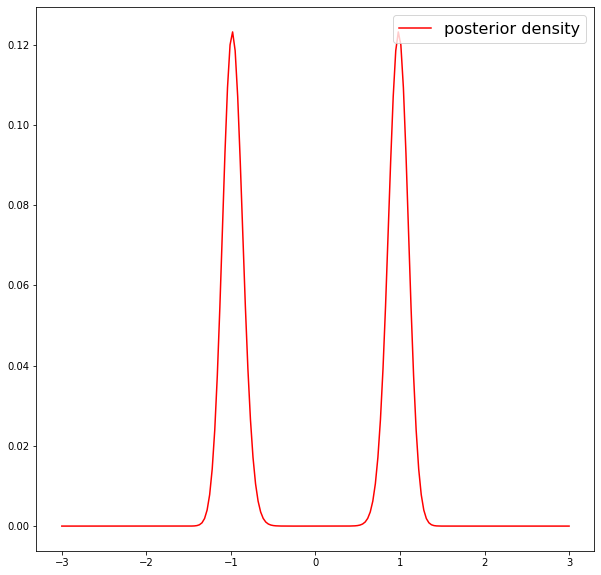

In [9]:
plt.figure(figsize=(10, 10))
plt.plot(args,posterior_val,color='r',label='posterior density')
#plt.plot(P.polynomial.polyval(X_train[0,:N_pts-cur_lag],coefs_poly_theor[cur_lag,:]),color='b',label = 'theoretical approximation')
plt.legend(loc = 'upper right',fontsize = 16)
plt.show()

### Generate data

In [10]:
sampler = {"sampler":"ULA","burn_type":grad_type,"main_type":grad_type} # Sampling method

if sampler["sampler"] == "ULA":
    res = Generate_train(n_traj, sampler, Cur_pot, step, N_burn, N_train, d)
    res = np.asarray(res)
    traj,traj_grad = res[:,0,:,:],res[:,1,:,:]
else:
    res = Generate_train(n_traj, sampler, Cur_pot, step, N_burn, N_train, d)
    traj = []
    traj_grad = []
    for i in range(len(res)):
        traj.append(res[i][0])
        traj_grad.append(res[i][1])
        print("accepted = ",res[i][2])
    traj = np.asarray(traj)
    traj_grad = np.asarray(traj_grad)

ncores =  12


### Visualize training trajectories

In [11]:
#visualize_scatter_2d(traj[3,:,:])

In [12]:
print(traj[1,:,0])

[ 1.02281553  0.98414876  0.90040957 ... -1.36239123 -1.12316237
 -1.26249366]


In [13]:
res = traj.mean(axis=1)
print(res)

[[-0.39528837]
 [-0.28859996]
 [-0.07312929]
 [ 0.82293869]
 [ 0.6920289 ]
 [-0.46886134]
 [ 0.61773324]
 [-0.84557002]
 [-0.51263937]
 [-0.18601164]
 [ 0.02943923]
 [-0.06601821]
 [-0.9396932 ]
 [ 0.95291481]
 [-0.17563021]
 [-0.51149078]
 [-0.48658542]
 [ 0.00782274]
 [-0.10135854]
 [ 0.77510615]
 [ 0.73092801]
 [-0.4530384 ]
 [ 0.21807645]
 [ 0.2555334 ]]


### Run variance reduction

In [14]:
print(traj.shape)
print(traj_grad.shape)
#traj_grad = (-1)*traj_grad

(24, 50000, 1)
(24, 50000, 1)


In [15]:
test_seed = 1453
f_type = "sum"
params = {"ind":0}
#regularizer
lambda_reg = 1e-10
#polynomial degree
deg = 1
nbcores = multiprocessing.cpu_count()
trav = Pool(nbcores)
res = trav.starmap(Eval_ZVCV_1d, [(traj[i,:,:],traj_grad[i,:,:],f_type,deg,lambda_reg,W_test) for i in range (n_traj)])
trav.close()

In [16]:
res_arr = np.asarray(res)
print(res_arr.shape)

(24, 2, 4)


### Saving results

In [17]:
#np.save("results/rezende/RWM_linear_29_06.npy",res_arr)
print("Average vr rates:")
print("ZV:",np.mean(res_arr[:,1,0]/res_arr[:,1,1]))
print("CV:",np.mean(res_arr[:,1,0]/res_arr[:,1,2]))
print("ESVM:",np.mean(res_arr[:,1,0]/res_arr[:,1,3]))

Average vr rates:
ZV: 1.0146913810818161
CV: 0.29001995673323216
ESVM: 1.0256908994806972


### Comparison plots

In [18]:
title = ""
labels = ['Vanilla\n ULA', 'ULA \nwith ZV', 'ULA \nwith CV', 'ULA \nwith ESVM']

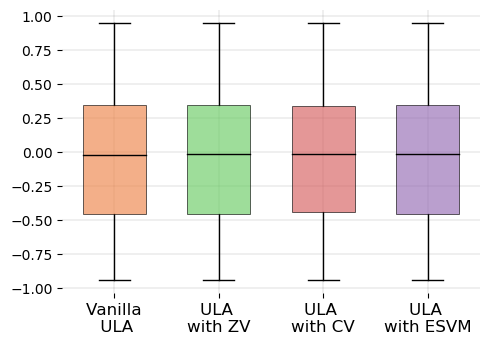

In [19]:
data = [res_arr[:,0,0],res_arr[:,0,1],res_arr[:,0,2],res_arr[:,0,3]] 
boxplot_ind(data, title, labels, path = "results/mixture_sgld/1storder.pdf")

In [ ]:
title = ""
labels = ['Vanilla\n ULA', 'ULA \nwith ZV', 'ULA \nwith ESVM']

In [ ]:
data = [res_arr[:,0,0],res_arr[:,0,1],res_arr[:,0,3]] 
boxplot_ind(data, title, labels, path = "results/donut/ula_esvm.pdf")

In [ ]:
title = ""
labels = ['ULA \nwith ZV-1', 'ULA \nwith CV-1']

In [ ]:
data = [res_arr[:,0,1],res_arr[:,0,3]] 
boxplot_ind(data, title, labels)

In [ ]:
title = ""
labels = ['Vanilla\n MALA', 'MALA \nwith ZV-2', 'MALA \nwith CV-2']

In [ ]:
data = [res_arr[:,0,0],res_arr[:,0,2],res_arr[:,0,4]] 
boxplot_ind(data, title, labels)

In [ ]:
title = ""
labels = ['ULA \nwith ZV-2', 'ULA \nwith CV-2']

In [ ]:
data = [res_arr[:,0,2],res_arr[:,0,4]] 
boxplot_ind(data, title, labels)